In [1]:
import os, pickle, re, glob, time
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')
pd.set_option('precision', 2)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Figure 1A

In [2]:
# TODO get script from A02-3_itth_scores

### Figure 1B

In [3]:
# See entropy_vs_drug_resp_nok.ipynb

entropy_vs_drug_resp_df = pd.read_csv('../result/CIBERSORT_deconvolution/entropy_vs_drug_resp_df.csv')
entropy_vs_drug_resp_df.head()

,patient,barcode,acronym,entropy,drug_name,response
0,TCGA-FB-AAPY,TCGA-FB-AAPY-01A-11R-A41B-07,PAAD,1.59,Gemcitabine,Complete Response
1,TCGA-LP-A4AU,TCGA-LP-A4AU-01A-32R-A32Y-07,CESC,1.73,Cisplatin,Complete Response
2,TCGA-FU-A23L,TCGA-FU-A23L-01A-11R-A16R-07,CESC,1.27,Cisplatin,Complete Response
3,TCGA-86-8054,TCGA-86-8054-01A-11R-2241-07,LUAD,1.77,Paclitaxel,Complete Response
4,TCGA-86-8054,TCGA-86-8054-01A-11R-2241-07,LUAD,1.77,Cisplatin,Complete Response


Choose drugs with with more than 100 samples

In [4]:
drugs = ['Doxorubicin', 'Cisplatin', 'Paclitaxel', 'Gemcitabine', 'Docetaxel', 'Temozolomide']

entropy_vs_drug_resp_df = entropy_vs_drug_resp_df[entropy_vs_drug_resp_df['drug_name'].isin(drugs)]

Change response label to "Response" and "No Response"

In [5]:
response_label = ['Complete Response', 'Partial Response', 'Stable Disease', 'Clinical Progressive Disease']

entropy_vs_drug_resp_df.loc[entropy_vs_drug_resp_df['response'].isin(['Complete Response', 'Partial Response']), 'response2'] = 'Response'
entropy_vs_drug_resp_df.loc[entropy_vs_drug_resp_df['response'].isin(['Stable Disease', 'Clinical Progressive Disease']), 'response2'] = 'No Response'

In [6]:
entropy_vs_drug_resp_df.groupby(by=['drug_name', 'response2']).count()

patient  barcode  acronym  entropy  response
drug_name    response2                                                
Cisplatin    No Response       74       74       74       74        74
             Response         246      246      246      246       246
Docetaxel    No Response       39       39       39       39        39
             Response          67       67       67       67        67
Doxorubicin  No Response       39       39       39       39        39
             Response          67       67       67       67        67
Gemcitabine  No Response       87       87       87       87        87
             Response          74       74       74       74        74
Paclitaxel   No Response       52       52       52       52        52
             Response         108      108      108      108       108
Temozolomide No Response       98       98       98       98        98
             Response          10       10       10       10        10

##### Supplementary figure

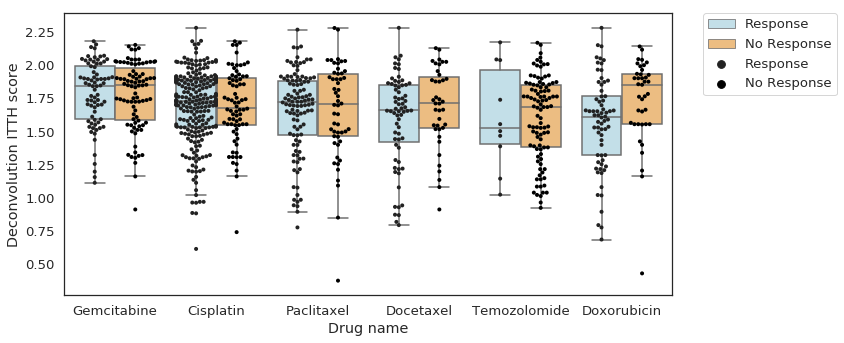

In [7]:
# Plot for all drugs

order = ['Response', 'No Response']

sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='drug_name', y='entropy', hue='response2', data=entropy_vs_drug_resp_df, hue_order=order, showfliers=False, palette='RdYlBu_r', ax=ax)

sns.swarmplot(x='drug_name', y='entropy', hue='response2', data=entropy_vs_drug_resp_df, hue_order=order, dodge=True, color='black', size=4, ax=ax)

plt.legend(title='Drug Response', bbox_to_anchor=(1.05, 1))
# plt.title('Shannon entropy vs Drug response')

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:4], labels[0:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Drug name')
plt.ylabel('Deconvolution ITTH score')

plt.tight_layout()

plt.savefig('../figure/supplementary_fig1_drug_response_vs_ITTH.svg')

##### Main

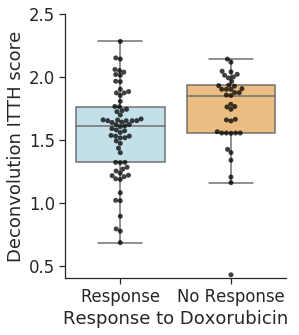

In [10]:
# Plot for Doxorubicin

sns.set(style='ticks', font_scale=1.5)
fig, ax = plt.subplots(figsize=(4.5,5))

order = ['Response', 'No Response']

doxo_df = entropy_vs_drug_resp_df[entropy_vs_drug_resp_df['drug_name'] == 'Doxorubicin']

sns.boxplot(x='response2', y='entropy', data=doxo_df, order=order, showfliers=False, palette='RdYlBu_r', ax=ax) # palette='RdYlBu_r'
sns.swarmplot(x='response2', y='entropy', data=doxo_df, order=order, color='black', ax=ax, alpha=0.75)
sns.despine(bottom=False)

plt.xticks(rotation=0)
plt.yticks()
plt.ylim((0.4, 2.5))
plt.xlabel('Response to Doxorubicin')
plt.ylabel('Deconvolution ITTH score')

plt.tight_layout()

plt.savefig('../figure/Figure1C.svg')

In [9]:
r = doxo_df[doxo_df['response2']=='Response']['entropy'].values
nr = doxo_df[doxo_df['response2']=='No Response']['entropy'].values
print (stats.ttest_ind(r, nr))
print (stats.ranksums(r, nr))

Ttest_indResult(statistic=-2.471424435888074, pvalue=0.015081045775039891)
RanksumsResult(statistic=-2.7548314314206994, pvalue=0.005872238123245004)


### Figure 1C

In [29]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, pairwise_logrank_test

dead_alive_map = {'Dead':1, 'Alive':0}

In [30]:
# See make_survival_avg_entropy_df.ipynb and lifelines_nok_update.ipynb

survival_vs_entropy_df = pd.read_pickle('../data/TCGA/survival_avg_entropy_df_binned.pkl')

In [31]:
avg_ent = survival_vs_entropy_df['avg_entropy']

q1 = np.percentile(avg_ent, 25)
q3 = np.percentile(avg_ent, 75)

print (q1, q3)
survival_vs_entropy_df.groupby('sort_entropy').count()

# sns.distplot(avg_ent, kde=False)

1.469801741262287 1.8736046803576698


,patient,acronym,days_to_death,vital_status,days_to_last_followup,duration,avg_entropy
sort_entropy,,,,,,,
high,2336,2336,772,2336,1878,2336,2336
low,2336,2336,609,2336,1946,2336,2336
med,4671,4671,1378,4671,3850,4671,4671


In [32]:
survival_vs_entropy_df.head()

,patient,acronym,days_to_death,vital_status,days_to_last_followup,duration,avg_entropy,sort_entropy
0,TCGA-OR-A5J1,ACC,1355.0,1,NaN,1355.0,2.17,high
1,TCGA-OR-A5J2,ACC,1677.0,1,NaN,1677.0,1.73,med
2,TCGA-OR-A5J3,ACC,NaN,0,2091.0,2091.0,1.90,high
3,TCGA-OR-A5J5,ACC,365.0,1,NaN,365.0,1.91,high
4,TCGA-OR-A5J6,ACC,NaN,0,2703.0,2703.0,2.05,high


##### Supplementary

In [33]:
acronym_list = sorted(survival_vs_entropy_df['acronym'].unique().tolist())

cmap = plt.cm.get_cmap('inferno', 10)
low_color = cmap(0.7)
med_color = cmap(0.5)
high_color = cmap(0.25)

In [34]:
def check_sig(results):
    if len(results.p_value) == 1:
        cmp_text = 'L/M' + str(' ({:.2e})'.format(results.p_value[0]))
    else:
        p_vals = results.p_value * len(results.p_value)
        cmp_text = 'L/M' + str(' ({:.2e})'.format(p_vals[0])) + '\n'
        cmp_text += 'L/H' + str(' ({:.2e})'.format(p_vals[1])) + '\n'
        cmp_text += 'M/H' + str(' ({:.2e})'.format(p_vals[2])) 
    
    ax.set_title(a + '\n' + cmp_text)      

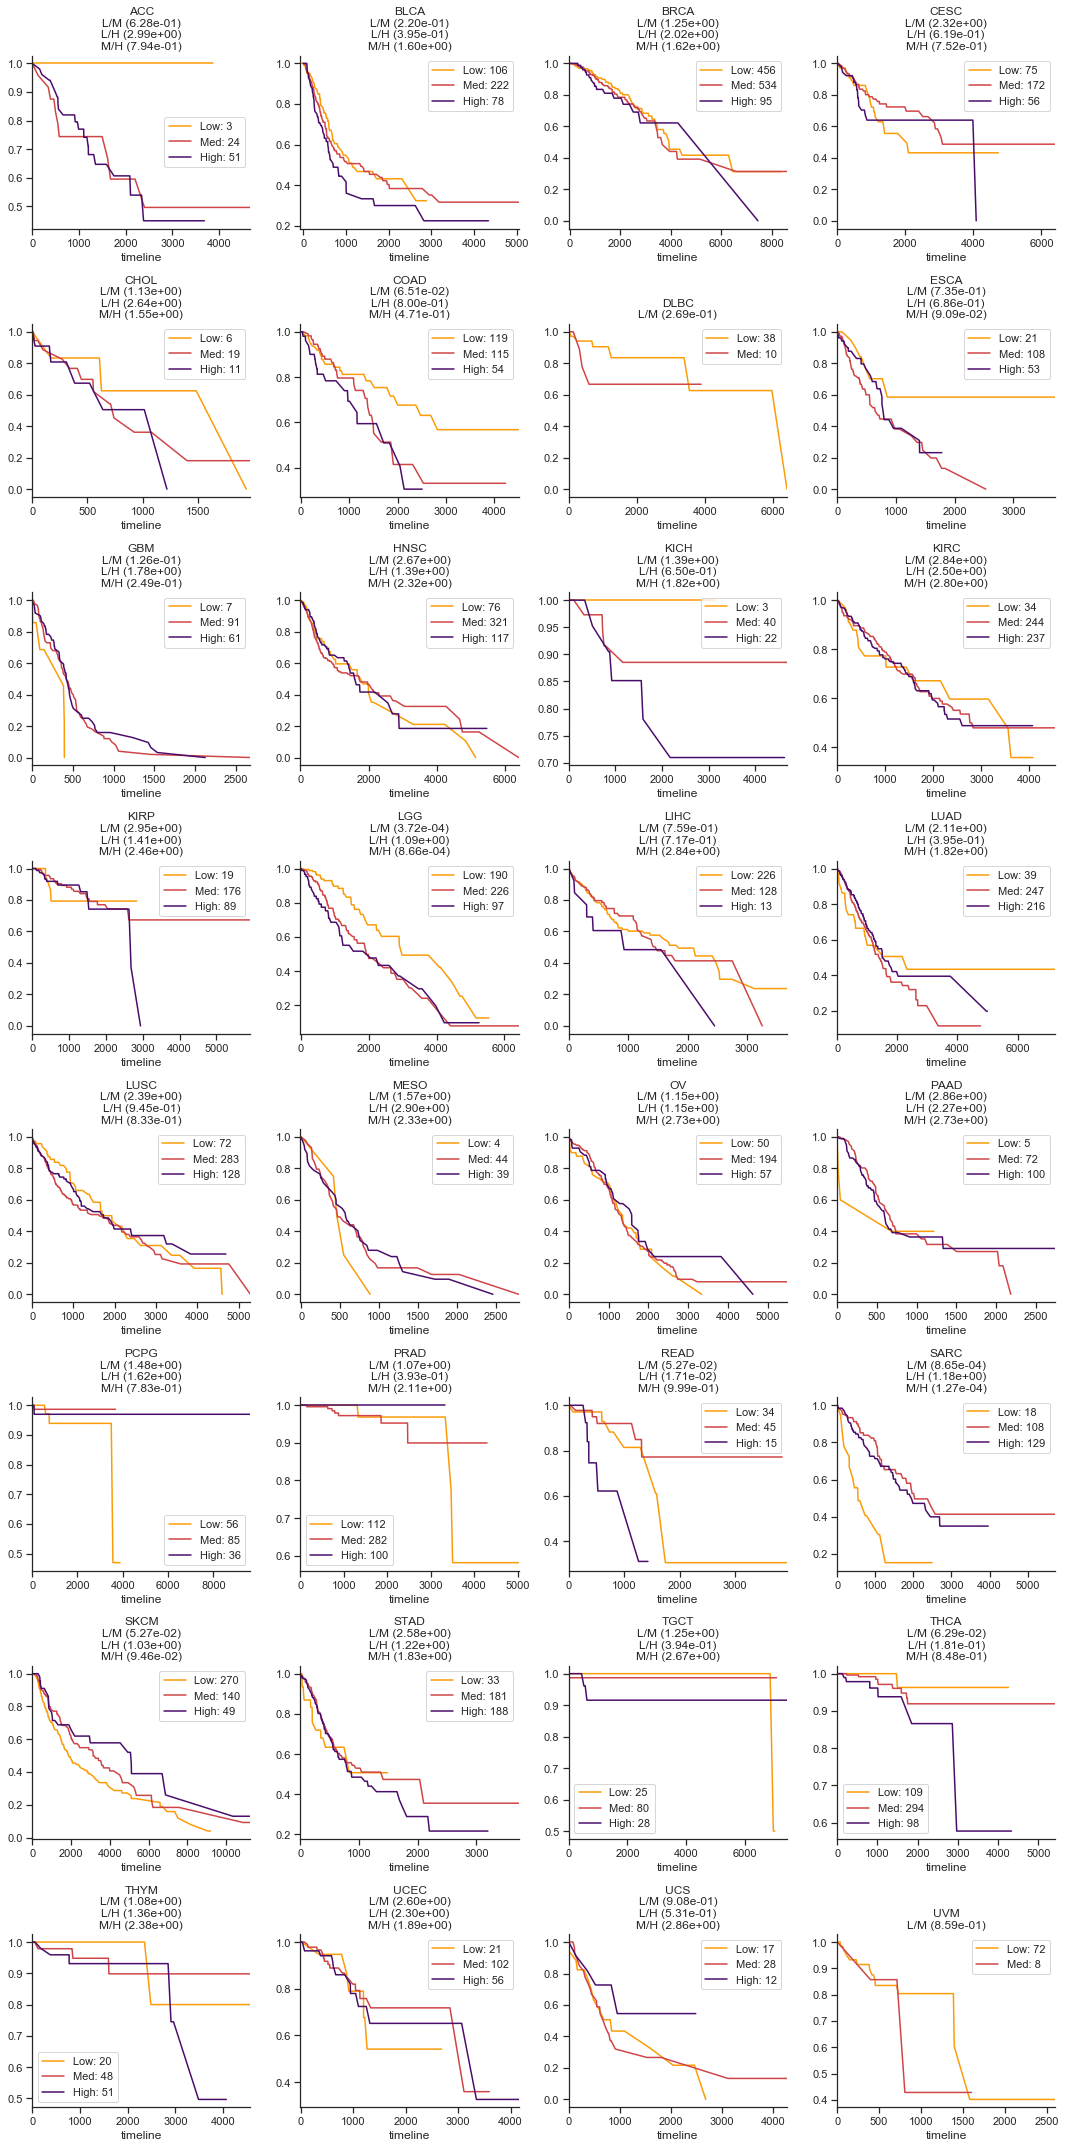

In [45]:
kmf_acr = KaplanMeierFitter() 

sns.set(font_scale=1, style='ticks')
fig, axes = plt.subplots(8, 4, figsize=(15, 30))

for a, ax in zip(acronym_list, axes.flatten()):
    df = survival_vs_entropy_df[survival_vs_entropy_df.acronym == a]
    
    df_low = df[df.sort_entropy == 'low']
    df_med = df[df.sort_entropy == 'med']
    df_high = df[df.sort_entropy == 'high']
    
    n_low = len(df_low)
    n_med = len(df_med)
    n_high = len(df_high)
    
    ax.set_xlim(0, 11260)

    kmf_acr.fit(df_low.duration, df_low.vital_status, label=('Low: ' + str(n_low)))
    kmf_acr.survival_function_.plot(ax=ax, color=low_color)  
   
    kmf_acr.fit(df_med.duration, df_med.vital_status, label=('Med: ' + str(n_med)))
    kmf_acr.survival_function_.plot(ax=ax, color=med_color)  

    # Not all of them have a high
    try:
        kmf_acr.fit(df_high.duration, df_high.vital_status, label=('High: ' + str(n_high)))
        kmf_acr.survival_function_.plot(ax=ax, color=high_color)  
    except ValueError:
        pass
    
    sns.despine()
    
    results = pairwise_logrank_test(df['duration'], df['sort_entropy'], df['vital_status'])
    check_sig(results)

plt.tight_layout()
plt.savefig('../figure/supplementary_itth_survival.svg')
plt.savefig('../figure/supplementary_itth_survival.pdf')

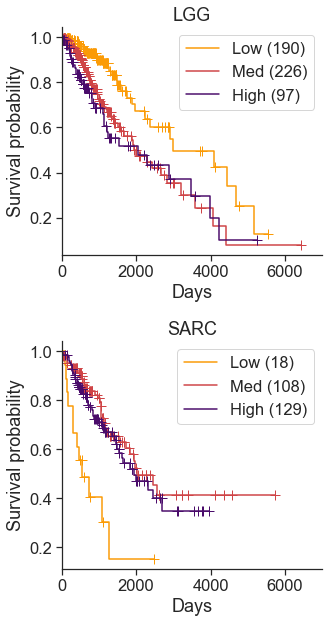

In [44]:
sns.set(style='ticks', font_scale=1.5)
fig, axes = plt.subplots(figsize=(5,9), ncols=1, nrows=2)

for a, ax in zip(['LGG', 'SARC'], axes.flatten()):
    df = survival_vs_entropy_df[survival_vs_entropy_df.acronym == a]
    
    df_low = df[df.sort_entropy == 'low']
    df_med = df[df.sort_entropy == 'med']
    df_high = df[df.sort_entropy == 'high']
    
    n_low = len(df_low)
    n_med = len(df_med)
    n_high = len(df_high)
    

    kmf_acr.fit(df_low.duration, df_low.vital_status, label=('Low ({})'.format(n_low)))
    kmf_acr.plot(ax=ax, color=low_color, show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
   
    kmf_acr.fit(df_med.duration, df_med.vital_status, label=('Med ({})'.format(n_med)))
    kmf_acr.plot(ax=ax, color=med_color, show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)

    # Not all of them have a high
    try:
        kmf_acr.fit(df_high.duration, df_high.vital_status, label=('High ({})'.format(n_high)))
        kmf_acr.plot(ax=ax, color=high_color, show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.05)
    except ValueError:
        pass
    
    ax.set_xlim(0, 7000)
    
    results = pairwise_logrank_test(df['duration'], df['sort_entropy'], df['vital_status'])
    ax.set_title(a)
    ax.set_ylabel('Survival probability')
    ax.set_xlabel('Days')
    
    sns.despine()

plt.tight_layout()   

plt.savefig('../figure/Figure1C.svg')

### Figure 1D

**TODO** Update D and E using new clustering based on marker genes

In [85]:
# See nok_nmf_all_cancer_type.ipynb and nok_nmf_all_cancer_type_marker_genes.ipynb and nok_nmf_lifelines.ipynb

# cluster_df = pd.read_csv('../data/TCGA/nmf_all_cancer_type.csv', index_col=0)
cluster_df = pd.read_csv('../data/TCGA/nmf_all_cancer_type_marker_genes.csv', index_col=0)

In [86]:
cluster_df.loc[:, 'patient'] = patient_id = ['-'.join(p.split('-')[0:3]) for p in cluster_df.index]
cluster_df.index.name = 'sample_id'
cluster_df = cluster_df.reset_index()

For patient with multiple samples, keep the cluster with higer si

In [87]:
patient_with_multiple_samples = [k for k, v in Counter(cluster_df['patient']).items() if v > 1]
len(patient_with_multiple_samples)

726

In [88]:
cluster_df = cluster_df.sort_values(['patient', 'si_score'], ascending=[True, False]).drop_duplicates(subset=['patient'], keep='first')

cluster_df = cluster_df.set_index('patient')
cluster_df.shape

(9418, 4)

In [89]:
cluster_df.head()

,sample_id,cancer_type,cluster,si_score
patient,,,,
TCGA-02-0047,TCGA-02-0047-01A-01R-1849-01,GBM,0,0.50
TCGA-02-0055,TCGA-02-0055-01A-01R-1849-01,GBM,0,0.19
TCGA-02-2483,TCGA-02-2483-01A-01R-1849-01,GBM,0,0.55
TCGA-02-2485,TCGA-02-2485-01A-01R-1849-01,GBM,0,0.55
TCGA-02-2486,TCGA-02-2486-01A-01R-1849-01,GBM,1,0.32


In [90]:
survival_vs_entropy_df = pd.read_pickle('../data/TCGA/survival_avg_entropy_df_binned.pkl')
survival_vs_entropy_df = survival_vs_entropy_df.set_index('patient')

survival_vs_entropy_df = pd.merge(survival_vs_entropy_df, cluster_df, left_index=True, right_index=True)

##### Supplementary

In [91]:
acronym_list = sorted(survival_vs_entropy_df['acronym'].unique().tolist())

cmap = plt.cm.get_cmap('tab10', 10)
colors = [cmap(i) for i in range(10)]

In [92]:
from scipy.special import comb

def check_sig(results, bf_coef):
    
    text_list = []
    for _, data in results.summary.reset_index().iterrows():
        x_name = int(data['level_0']+1)
        y_name = int(data['level_1']+1)
        pval = data['p'] * bf_coef

        text = "TC {}/TC {} ({:.2e})".format(x_name, y_name, pval)

#         if pval <= 0.05:
#             text += ' (*)'

        text_list += [text]

    ax.set_title('\n'.join([a] + text_list))     

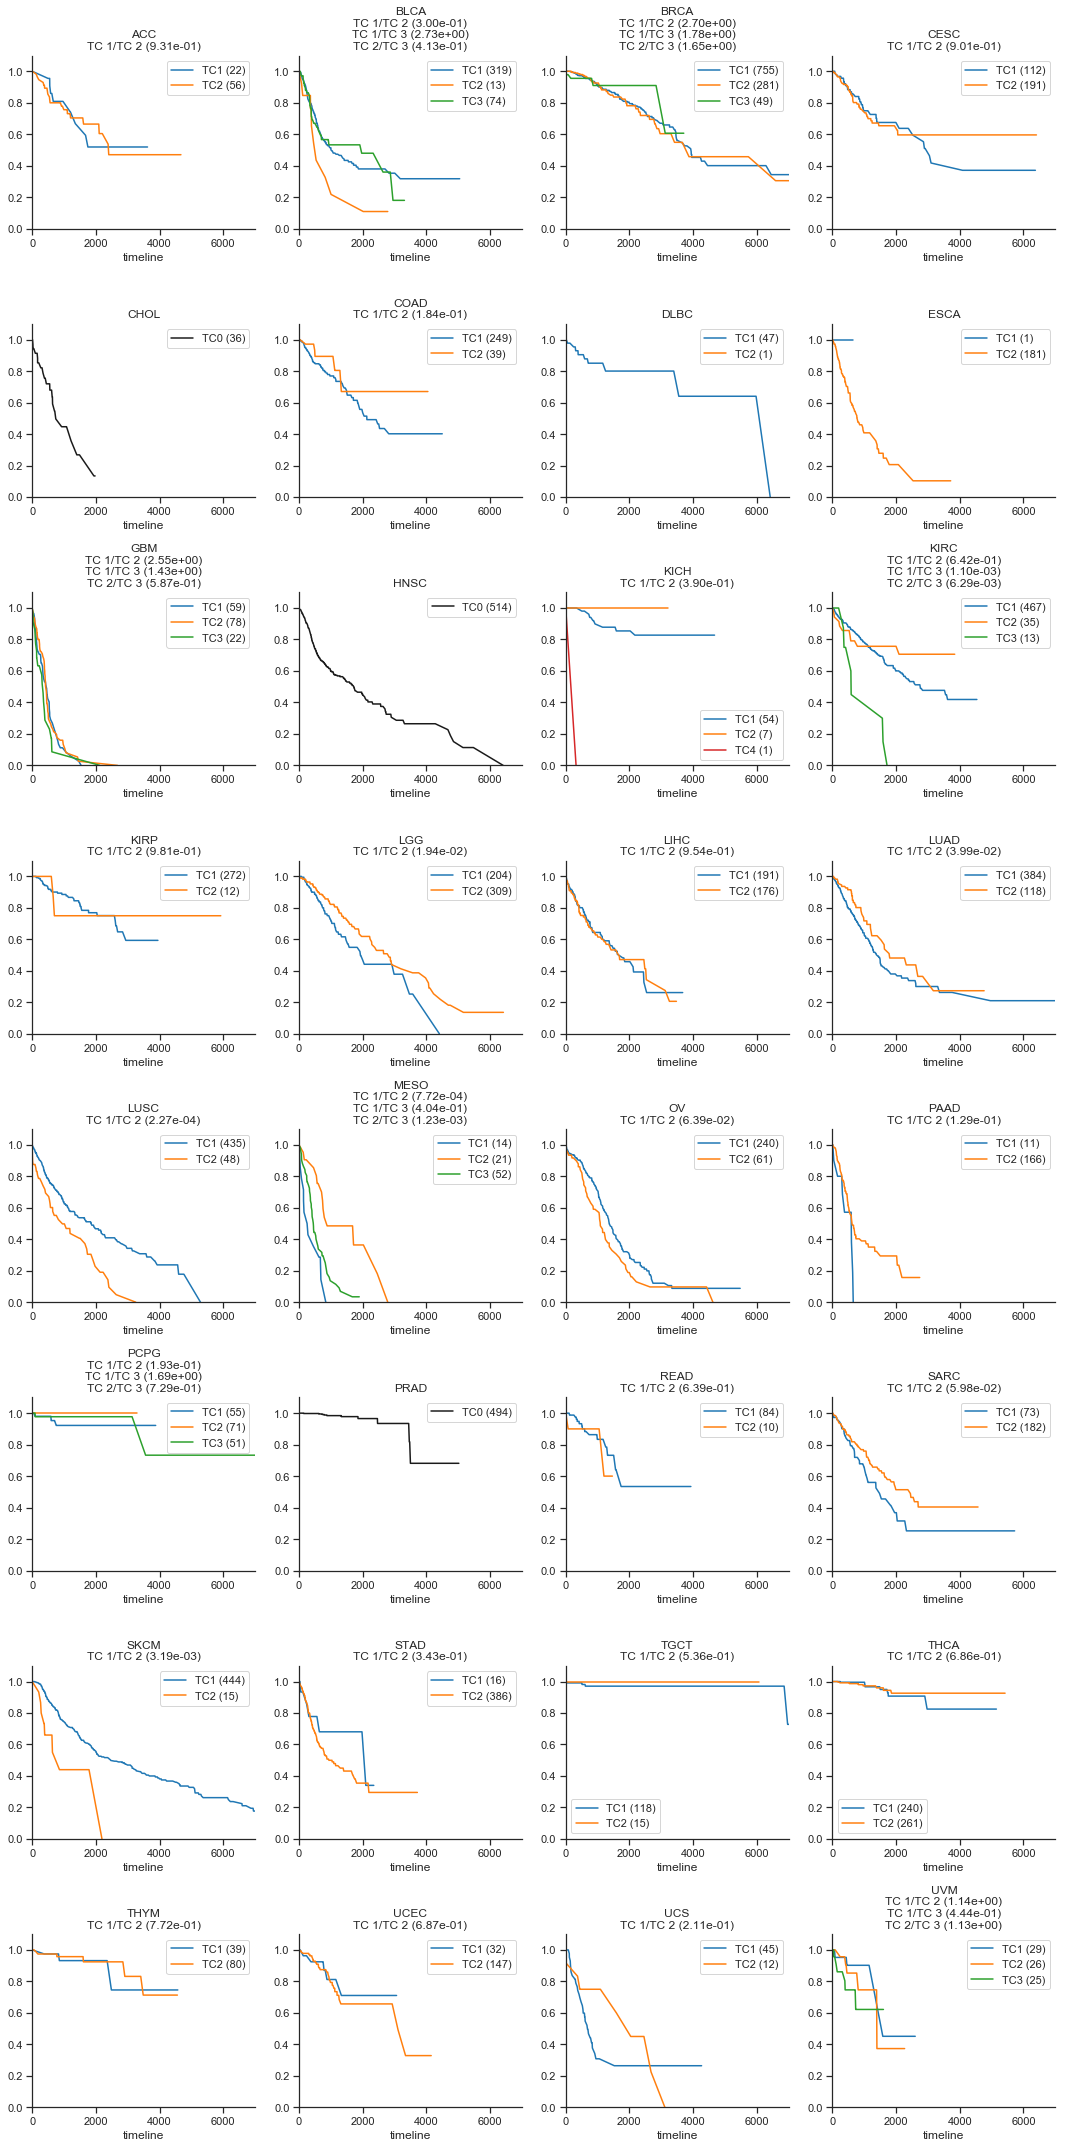

In [54]:
kmf_acr = KaplanMeierFitter() 
min_n_sample = 5

sns.set(font_scale=1, style='ticks')
fig, axes = plt.subplots(8, 4, figsize=(15, 30))

for a, ax in zip(acronym_list, axes.flatten()):
    df = survival_vs_entropy_df[survival_vs_entropy_df.acronym == a]
    
    n_cluster = len(df['cluster'].unique())
#     print (a, n_cluster, comb(n_cluster, 2))
    
    # there are two cancer types that 
    if n_cluster < 2:
        kmf_acr.fit(df.duration, df.vital_status, label='TC0 ({:d})'.format(df.shape[0]))
        kmf_acr.survival_function_.plot(ax=ax, color='k')
        ax.set_title(a)
    else:
        c_df_list = []
        c_to_test = []
        for c in range(n_cluster):
            c_df = df[df['cluster'] == c]
            if c_df.shape[0] > 0:
                kmf_acr.fit(c_df.duration, c_df.vital_status, label='TC{:d} ({:d})'.format(c+1, c_df.shape[0]))
                kmf_acr.survival_function_.plot(ax=ax, color=colors[c])
                if c_df.shape[0] >= min_n_sample:
                    c_to_test += [c]
        
        df = df[df['cluster'].isin(c_to_test)]
        results = pairwise_logrank_test(df['duration'], df['cluster'], df['vital_status'])
        check_sig(results, comb(len(c_to_test), 2))
    
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 7000)

sns.despine()
plt.tight_layout()

plt.savefig('../figure/supplementary_nmf_survival.svg')
plt.savefig('../figure/supplementary_nmf_survival.pdf')

##### Main

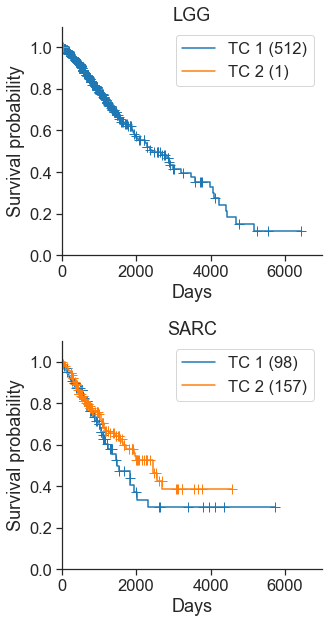

In [93]:
sns.set(style='ticks', font_scale=1.5)
fig, axes = plt.subplots(figsize=(5,9), ncols=1, nrows=2)


for a, ax in zip(['LGG', 'SARC'], axes.flatten()):
    df = survival_vs_entropy_df[survival_vs_entropy_df.acronym == a]
    
    n_cluster = len(df['cluster'].unique())
#     print (a, n_cluster, comb(n_cluster, 2))
    
    
    # there are two cancer types that 
    if n_cluster < 2:
        kmf_acr.fit(df.duration, df.vital_status, label='TC 1 ({:d})'.format(df.shape[0]))
        kmf_acr.plot(ax=ax, color=colors[0], show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
        ax.set_title(a)
    else:
        c_df_list = []
        c_to_test = []
        for c in range(n_cluster):
            c_df = df[df['cluster'] == c]
            if c_df.shape[0] > 0:
                kmf_acr.fit(c_df.duration, c_df.vital_status, label='TC {:d} ({:d})'.format(c+1, c_df.shape[0]))
                kmf_acr.plot(ax=ax, color=colors[c], show_censors=True, censor_styles={'ms': 10, 'marker': '+'}, ci_show=False, ci_alpha=0.1)
        ax.set_title(a)

    ax.set_ylabel('Survival probability')
    ax.set_xlabel('Days')
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 7000)

sns.despine()
plt.tight_layout()

# plt.savefig('../figure/Figure1D.svg')

### Figure 1E

In [81]:
# See nok_ith_vs_nmf.ipynb

cancer_type = 'LGG'
# cancer_type = 'SARC'

cnt_df = survival_vs_entropy_df[survival_vs_entropy_df['acronym']==cancer_type][['sample_id', 'cluster', 'sort_entropy']]
cnt_df = cnt_df.groupby(by=['cluster', 'sort_entropy']).count().reset_index().pivot(index='cluster', columns='sort_entropy')

cnt_df

sample_id          
sort_entropy      high  low  med
cluster                         
0                   59   35  110
1                   38  155  116

In [82]:
union_df = pd.DataFrame(index=cnt_df.index, columns=cnt_df.columns).fillna(0)
union_df = ((union_df + cnt_df.sum()).T + cnt_df.sum(axis=1)).T
union_df

sample_id          
sort_entropy      high  low  med
cluster                         
0                  301  394  430
1                  406  499  535

In [83]:
jc_df = cnt_df / (union_df - cnt_df)
jc_df.columns = ['Low', 'Med', 'High']
jc_df.index = ["TC {}".format(i+1) for i in jc_df.index]

jc_df = jc_df.fillna(0)

jc_df

,Low,Med,High
TC 1,0.24,0.10,0.34
TC 2,0.10,0.45,0.28


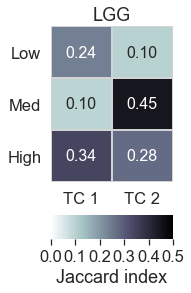

In [84]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(3,4.5))
cmap = plt.cm.get_cmap('bone_r')

ax = sns.heatmap(jc_df.T, cmap=cmap, vmin=0, vmax=0.5, annot=True, annot_kws={'fontsize':16}, fmt='.2f', linewidth=1, linecolor='lightgrey', cbar_kws={"label":"Jaccard index", "orientation": "horizontal", "shrink": 1, 'aspect':5})

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title(cancer_type)
plt.tight_layout()

plt.savefig('../figure/Figure1E_{}.svg'.format(cancer_type))